# Food Vision Classifier

The purpose of this project is to explore computer vision by analyzing the food-101 dataset. Ultimately, the final outcome of this project is to outperform the model built and trained in the DeepFood paper (see link below), at peak performance of 77.4% accuracy when running on the same test dataset used in this notebook.

* https://arxiv.org/pdf/1606.05675.pdf

The starting point will consist of using the EfficientNetB0 model as a baseline, and fine-tune and improve upon each model to outperform the DeepFood paper.

**NOTE**: This notebook is ongoing. Due to the time it takes to train a model, I have limited the number of experiments I have run. I plan to continue to explore this dataset with new models and training hyper parameters.

## Setup

Google Colab offers free GPU's, however, not all of them are compatible with mixed precision training.

Models Include:
* K80 (Not Compatible)
* P100 (Not Compatible)
* Tesla T4 (Compatible)

Knowing this, in order to use mixed precision training, we need access to a Tesla T4 from within Google Colab. If we are using our own hardware, the GPU needs a score of 7.0+.

In [2]:
# Determining if on google colab
try:
  from google import colab
  on_colab = True
except Exception:
  on_colab = False

on_colab

True

In [3]:
# Installing my personal repo that contains all my utils as a package
if on_colab:
  !nvidia-smi -L
  !pip install py-learning-toolbox@git+https://github.com/bkubick/py-learning-toolbox.git
  !pltb_setup_project .

GPU 0: Tesla T4 (UUID: GPU-a6e3974e-92b7-abd1-5f17-8d5ce2012239)
  Cloning https://github.com/bkubick/py-learning-toolbox.git to /tmp/pip-install-jka06whr/py-learning-toolbox_a37ae6dbce16460cb7f4039a7b89b46c
  Running command git clone --filter=blob:none --quiet https://github.com/bkubick/py-learning-toolbox.git /tmp/pip-install-jka06whr/py-learning-toolbox_a37ae6dbce16460cb7f4039a7b89b46c
  Resolved https://github.com/bkubick/py-learning-toolbox.git to commit 0fa268215ca61839914e6babe9c1b128f3e24bbe
  Preparing metadata (setup.py) ... done


## Imports

In [43]:
import datetime
import logging
import os
import pathlib
import random
import sys
import typing

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from py_learning_toolbox import data_toolbox
from py_learning_toolbox import ml_toolbox
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow_hub as hub

## Environment

Setting up the environment and analyzing the various information associated with this notebook.

In [5]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-09-24 16:29:47.730443


In [6]:
tf.__version__

'2.13.0'

In [7]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# Setting up logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Setup Mixed Precision Training

For a deeper understanding of mixed precision training, checkout the TensorFlow guide:

* https://www.tensorflow.org/guide/mixed_precision

Mixed precision utlizes a combination of float16 and float32 datatypes to speed up training.

NOTE: This is only useful when running on colab with an Nvidia GPU, otherwise it will have the opposite effect and slow it down.

In [9]:
if on_colab:
    # Turn on mixed precision training (only works if compatible GPU)
    tf.keras.mixed_precision.set_global_policy('mixed_float16') # sets the mixed precision policy to float16
    tf.keras.mixed_precision.global_policy()

## Global Constants

In [12]:
RANDOM_SEED = 42
IMAGE_SIZE = 224

## Helpers

In [11]:
def summarize_model_layer_parameters(model: tf.keras.models.Model) -> None:
  """ Helper function to print out certain parameter values for each layer in a
      given model. Parameters it prints are:

      - layer.name
      - layer.trainable
      - layer.dtype
      - layer.dtype_policy

      Args:
        model (tf.keras.models.Model): The model of which to summarize the layers.
  """
  for layer in model.layers:
    print(f'{layer.name} trainable={layer.trainable} dtype={layer.dtype} dtype_policy={layer.dtype_policy}')

In [163]:
def generate_prediction_metrics(model: tf.keras.models.Model,
                                data: tf.data.Dataset) -> ml_toolbox.analysis.classification.ClassificationPredictionMetrics:
    """ Helper to generate prediction metrics on the corresponding dataset.

        Due to the way the data is loaded, the data batches shuffle everytime
        it is called, resulting in the predictions not matching the labels when
        extract the labels from the dataset. This helper predicts a single batch
        at a time that way it can keep track of the predictions and the corresponding
        label.

        Args:
            model (Model): the corresponding model to use to make predictions.
            data (tf.data.Dataset): the corresponding dataset to make predictions on.

        Returns:
            (ClassificationPredictionMetrics) the classification metrics.
    """
    total_batches = len(data)

    pred_probs = []
    true_labels = []
    for i, (data_batch, label_batch) in enumerate(data):
      percentile = i/total_batches * 100
      if percentile % 10 == 0:
        print(f'Completed Predictions: {percentile}%')

      true_labels.extend(label_batch.numpy())
      pred_probs.extend(model.predict(data_batch, verbose=None))

    true_labels = tf.convert_to_tensor(true_labels)
    pred_probs = tf.convert_to_tensor(pred_probs)
    preds = tf.argmax(pred_probs, axis=1)

    return ml_toolbox.analysis.classification.generate_prediction_metrics(true_labels, preds, name=model.name)

## Downloading, Analyzing, Preprocessing, & Creating Datasets

The dataset I will be using is the entire food101 dataset. I am going to be getting the dataset using [TensorFlow Datasets (TFDS)](https://blog.tensorflow.org/2019/02/introducing-tensorflow-datasets.html?_gl=1*ooskag*_ga*ODA4ODcwNzEyLjE2ODgwNDkyMDI.*_ga_W0YLR4190T*MTY5NTQxNTI0OC44Ni4xLjE2OTU0MTUyNDkuMC4wLjA.).



### Loading Dataset

In [113]:
# Load in the food-101 dataset from tfds (NOTE: this can take about 5-6 minutes to fully load in google colab)
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True,  # Return type is tuple of (data, label)
                                             with_info=True)

### Analyzing Dataset

To better visualize the Food-101 data, there are some things I want to look at:

* Class names
* The shape of our input data
* The datatype of our input data
* The labels (e.g. are they one hot encoded, label encoded, etc)
* Do the labels match with the class names

In [123]:
# Seeing how many batches in train and test sets
len(train_data), len(test_data)

(2368, 790)

In [14]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [15]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10], len(class_names)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito'],
 101)

In [16]:
# Lets look at one sample of the training data
train_data_sample = train_data.take(1)

# Output info about training sample
for image, label in train_data_sample:
  print(f"""
    Image Shape: {image.shape}
    Image DataType: {image.dtype}
    Target Class from Food-101 (tensor form): {label}
    Class Name: {class_names[label.numpy()]}
  """)


    Image Shape: (489, 512, 3)
    Image DataType: <dtype: 'uint8'>
    Target Class from Food-101 (tensor form): 90
    Class Name: spaghetti_bolognese
  


In [17]:
# What does the image tensor look like?
tf.reduce_min(image), tf.reduce_max(image), image.dtype

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>,
 tf.uint8)

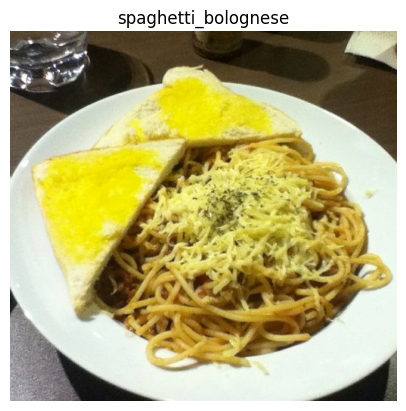

In [18]:
# What does the image look like
plt.figure()
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

### Preprocessing Data

Neural networks perform best when data is structured in a certain way (e.g. batched, normalized, etc.). Not all data, including from tensorflow datasets, comes structured nicel. In order to properly utilize a Neural Network, the data needs to be preprocessed to cleanup and erstructure our data.

Findings from looking at our data:
* Data is in uint8 datatype
* Data is composed of different sized images
* Data is not normalized (e.g. pixels between 0-255 instead of 0-1)

What Structure Models Perform Best With:
* Data in float32 (or for mixed precision, float16 and float32)
* For batches, all the tensors within batch are of the same size
* Pixels scaled (between 0 & 1) generally perform better.

With this in mind, there are a few things I need to do to get the data structured properly. Since I am going to be using an EfficientNetBX base trained model, the scaling will be taken care of for me because it is already built into the model.

In [19]:
preprocess_image = ml_toolbox.preprocessing.image.generate_preprocess_image_function(img_shape=IMAGE_SIZE)

In [20]:
# Lets test this out
image, label = next(iter(train_data.take(1)))

preprocessed_image, preprocessed_label = preprocess_image(image, label)

preprocessed_image.shape, preprocessed_image.dtype

(TensorShape([224, 224, 3]), tf.float32)

### Creating Datasets

Creating performant data pipelines with tensorflow. I need to make this pipeline run fast. For more resources on how to do this, read the following docs:

* https://www.tensorflow.org/guide/data_performance

In [97]:
# Constants
BUFFER_SIZE = 1000
BATCH_SIZE = 32

In [114]:
# Map preprocessing function to training data, and parallelize it
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle the train_data and turn into batches
train_data = train_data.shuffle(buffer_size=BUFFER_SIZE).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data, and parallelize it
test_data = test_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Turn test_data into batches
test_data = test_data.batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

# Verify that the shape changed, dtype change, and the dataset is a PrefetchDataset
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Experiments

I am going to perform a handful of experiments to hopefully create a model capable of predicting food images and classifying them correctly. My goal is to outperform the corresponding paper associated with this notebook as mentioned in the description.

* Experiment-0: Feature Extraction Model (No Fine Tuning)
* Experiment-1: Fine Tuning Last 40 Layers of Experiment-0
* Experiment-2: Fine Tuning Last 20 Layers of Experiment-0

### Experiment Constants

Common constants used across many/all experiments.

In [24]:
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
OUTPUT_SIZE = 101  # Number of food classes

TRAIN_STEPS_PER_EPOCH = len(train_data)
VAL_STEPS_PER_EPOCH = int(len(test_data) * 0.15)

### Experiment-0 (Baseline): Feature Extraction Model

The first model (`model_0`) is going to be the baseline model on which to analyze each model against. The purpose of this is to determine whether each model improved following the fine tuned adjustments made.

#### Constants/Hyper Parameters

In [25]:
# Constants
model_0_name = 'model_0_feature_extraction'
model_0_filepath = f'./models/{model_0_name}'

EPOCHS_0 = 3

#### Creating Model

In [38]:
# Create base model from EfficientNetB0
base_model_0 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_0.trainable = False

# Create functional model
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name='InputLayer')
x = base_model_0(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name='GlobalAveragePoolingLayer')(x)
x = tf.keras.layers.Dense(OUTPUT_SIZE)(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32, name='SoftmaxOutputLayer')(x)

# Creating model
model_0 = tf.keras.models.Model(inputs, outputs, name=model_0_name)

In [39]:
# Compile Model
model_0.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

#### Analyzing Model

In [28]:
# Lets get some summaries of the model
model_0.summary()

Model: "model_0_feature_extraction"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 GlobalAveragePoolingLayer   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 SoftmaxOutputLayer (Activa  (None, 101)               0         
 tion)                                                           
                                        

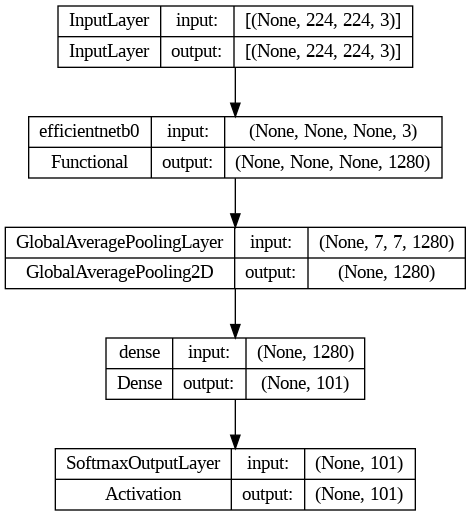

In [29]:
ml_toolbox.analysis.model.plot_model(model_0)

In [30]:
# Lets look at the datatype of each layer to tell if we are using mixed precision
summarize_model_layer_parameters(model_0)

InputLayer trainable=True dtype=float32 dtype_policy=<Policy "float32">
efficientnetb0 trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
GlobalAveragePoolingLayer trainable=True dtype=float32 dtype_policy=<Policy "mixed_float16">
dense trainable=True dtype=float32 dtype_policy=<Policy "mixed_float16">
SoftmaxOutputLayer trainable=True dtype=float32 dtype_policy=<Policy "float32">


In [31]:
# Lets look at the datatype of each layer of the base_model to tell if we are using mixed precision
summarize_model_layer_parameters(base_model_0)

input_1 trainable=False dtype=float32 dtype_policy=<Policy "float32">
rescaling trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
normalization trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
rescaling_1 trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
stem_conv_pad trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
stem_conv trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
stem_bn trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
stem_activation trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_dwconv trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_bn trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_activation trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_se_squeeze trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_se_reshape trainable=False

#### Fitting Model

In [40]:
# Fit the model
model_0_history = model_0.fit(
    train_data,
    epochs=EPOCHS_0,
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    validation_data=test_data,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[
        ml_toolbox.modeling.callbacks.generate_checkpoint_callback(model_0_name, best_only=False),
        ml_toolbox.modeling.callbacks.generate_tensorboard_callback(model_0_name),
    ])

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:Checkpoint callback for checkpoints/model_0_feature_extraction/20230924-164636
INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/model_0_feature_extraction/tensorboard/20230924-164636


Epoch 1/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.7188 - accuracy: 0.5822
Epoch 1: saving model to checkpoints/model_0_feature_extraction/20230924-164636/checkpoint.ckpt
2368/2368 [==============================] - 104s 41ms/step - loss: 1.7189 - accuracy: 0.5822 - val_loss: 1.1144 - val_accuracy: 0.7058
Epoch 2/3
2366/2368 [============================>.] - ETA: 0s - loss: 1.2000 - accuracy: 0.6888
Epoch 2: saving model to checkpoints/model_0_feature_extraction/20230924-164636/checkpoint.ckpt
2368/2368 [==============================] - 96s 40ms/step - loss: 1.2003 - accuracy: 0.6888 - val_loss: 1.0230 - val_accuracy: 0.7222
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.0553 - accuracy: 0.7238
Epoch 3: saving model to checkpoints/model_0_feature_extraction/20230924-164636/checkpoint.ckpt
2368/2368 [==============================] - 96s 40ms/step - loss: 1.0553 - accuracy: 0.7238 - val_loss: 0.9976 - val_accuracy: 0.7246


#### Analyzing Performance

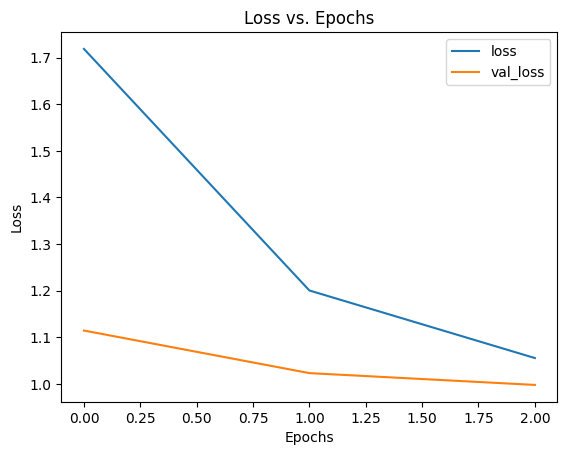

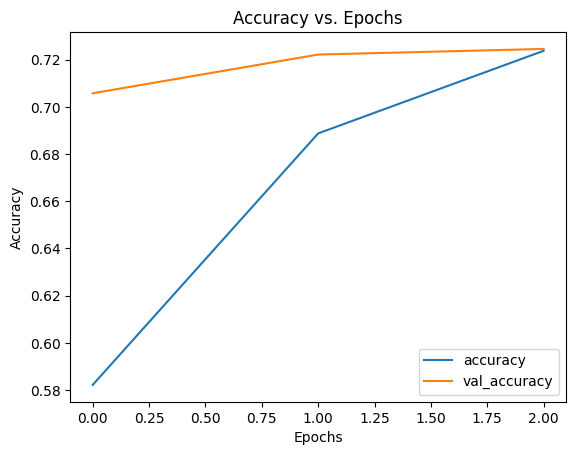

In [41]:
ml_toolbox.analysis.history.plot_history(model_0_history, metric='loss')
ml_toolbox.analysis.history.plot_history(model_0_history, metric='accuracy')

In [164]:
model_0_results = generate_prediction_metrics(model_0, test_data)
model_0_results

Completed Predictions: 0.0%
Completed Predictions: 10.0%
Completed Predictions: 20.0%
Completed Predictions: 30.0%
Completed Predictions: 40.0%
Completed Predictions: 50.0%
Completed Predictions: 60.0%
Completed Predictions: 70.0%
Completed Predictions: 80.0%
Completed Predictions: 90.0%


ClassificationPredictionMetrics(accuracy=0.7252673267326732, precision=0.7330422201323652, recall=0.7252673267326732, f1=0.7244350135974619, name='model_0_feature_extraction')

#### Exporting History & Model

In [47]:
ml_toolbox.analysis.history.export_history(model_0_history, model_0_name)

In [48]:
model_0.save(model_0_filepath)

### Determining Most Recent Model-0 Checkpoint (Required for Fine Tuning Experiments)

In [52]:
# Getting Model 0 last checkpoint to start Model 1 from
model_0_checkpoint_dirs = [dir for dir in os.listdir(f'./checkpoints/{model_0_name}/') if not dir.startswith('.')]

model_0_last_checkpoint = f'./checkpoints/{model_0_name}/{model_0_checkpoint_dirs[-1]}/checkpoint.ckpt'
model_0_last_checkpoint

'./checkpoints/model_0_feature_extraction/20230924-163118/checkpoint.ckpt'

### Experiment 1: Fine Tuning w/ Last 40 Layers Trainable

The first model to look at will introduce fine tuning into the previous model. This will allow adjusting and tuning parameters from the transfer learning base model to better adjust our model.

For this model, I will only allow the last 40 layers in the base model to be trainable, and all other layers will remain unchanged.

#### Constants/Hyper Parameters

In [50]:
# Constants
model_1_name = 'model_1_fine_tune_40'
model_1_filepath = f'./models/{model_1_name}'

NUM_TRAINABLE_LAYERS = 40

EPOCHS_1 = 100
LEARNING_RATE = 0.0001

#### Creating Model

In [165]:
# Starting from model_0 (Reloading in where model_0 left off from)
model_1 = tf.keras.models.clone_model(model_0)
model_1.load_weights(model_0_last_checkpoint)
model_1._name = model_1_name

# Setting the efficient net model to be trainable
base_model_1 = model_1.layers[1]
base_model_1.trainable = True

# Setting all but last 40 layers in base_model to be not traininable (only last 5 layers are trainable)
for layer in base_model_1.layers[:-NUM_TRAINABLE_LAYERS]:
    layer.trainable = False

In [166]:
# Recompiling the fine tuned model
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics=['accuracy'])

#### Analyzing Model

In [167]:
model_1.summary()

Model: "model_1_fine_tune_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 GlobalAveragePoolingLayer   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 SoftmaxOutputLayer (Activa  (None, 101)               0         
 tion)                                                           
                                              

In [56]:
# Lets look at the datatype of each layer of the base_model to tell if we are using mixed precision
summarize_model_layer_parameters(base_model_1)

input_2 trainable=False dtype=float32 dtype_policy=<Policy "float32">
rescaling_2 trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
normalization_1 trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
rescaling_3 trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
stem_conv_pad trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
stem_conv trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
stem_bn trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
stem_activation trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_dwconv trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_bn trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_activation trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_se_squeeze trainable=False dtype=float32 dtype_policy=<Policy "mixed_float16">
block1a_se_reshape trainable=F

#### Fitting Model

In [168]:
# Setting up Early Stopping Callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

# Fit the model
model_1_history = model_1.fit(
    train_data,
    epochs=EPOCHS_1,
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    validation_data=test_data,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[
        ml_toolbox.modeling.callbacks.generate_checkpoint_callback(model_1_name, best_only=False),
        ml_toolbox.modeling.callbacks.generate_tensorboard_callback(model_1_name),
        early_stopping_callback,
    ])

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:Checkpoint callback for checkpoints/model_1_fine_tune_40/20230924-184412
INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/model_1_fine_tune_40/tensorboard/20230924-184412


Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 1.5576 - accuracy: 0.6018
Epoch 1: saving model to checkpoints/model_1_fine_tune_40/20230924-184412/checkpoint.ckpt
2368/2368 [==============================] - 167s 61ms/step - loss: 1.5576 - accuracy: 0.6018 - val_loss: 1.0012 - val_accuracy: 0.7293
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 1.0080 - accuracy: 0.7301
Epoch 2: saving model to checkpoints/model_1_fine_tune_40/20230924-184412/checkpoint.ckpt
2368/2368 [==============================] - 138s 57ms/step - loss: 1.0080 - accuracy: 0.7301 - val_loss: 0.9253 - val_accuracy: 0.7463
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7578 - accuracy: 0.7885
Epoch 3: saving model to checkpoints/model_1_fine_tune_40/20230924-184412/checkpoint.ckpt
2368/2368 [==============================] - 116s 49ms/step - loss: 0.7578 - accuracy: 0.7885 - val_loss: 0.9564 - val_accuracy: 0.7500
Epoch 4/100
2368/2368 [==

#### Analyzing Performance

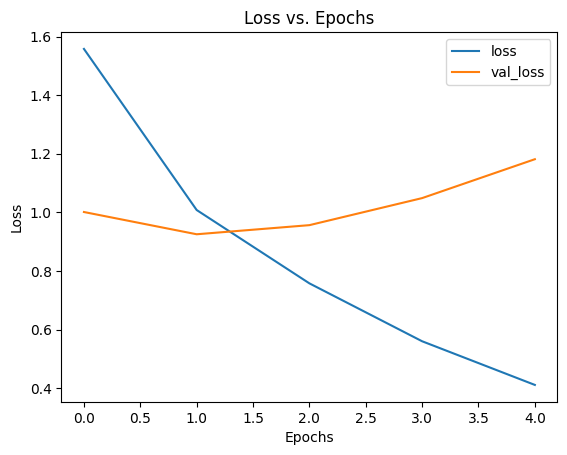

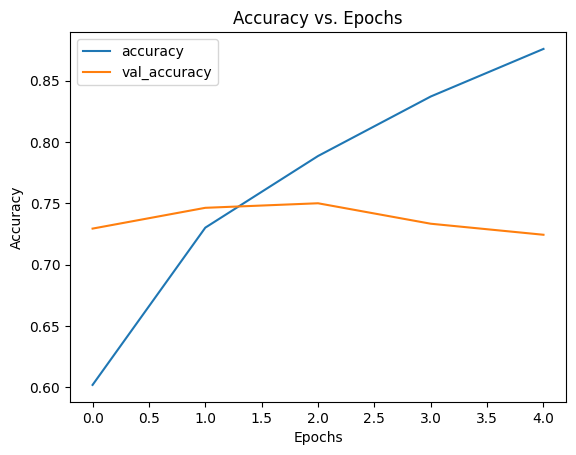

In [169]:
ml_toolbox.analysis.history.plot_history(model_1_history, metric='loss')
ml_toolbox.analysis.history.plot_history(model_1_history, metric='accuracy')

In [175]:
model_1_results = generate_prediction_metrics(model_1, test_data)
model_1_results

Completed Predictions: 0.0%
Completed Predictions: 10.0%
Completed Predictions: 20.0%
Completed Predictions: 30.0%
Completed Predictions: 40.0%
Completed Predictions: 50.0%
Completed Predictions: 60.0%
Completed Predictions: 70.0%
Completed Predictions: 80.0%
Completed Predictions: 90.0%


ClassificationPredictionMetrics(accuracy=0.7334257425742574, precision=0.7556380424257898, recall=0.7334257425742574, f1=0.7346852149831157, name='model_1_fine_tune_40')

### Experiment 2: Fine Tuning w/ 20 Layers Trainable

The second model to look at will introduce fine tuning into the previous model. This will allow adjusting and tuning parameters from the transfer learning base model to better adjust our model.

For this model, I will allow the last 20 layers from the base model to be trainable.

#### Constants/Hyper Parameters

In [174]:
# Constants
model_2_name = 'model_2_fine_tune_20'

NUM_TRAINABLE_LAYERS_2 = 20

EPOCHS_2 = 100
LEARNING_RATE = 0.0001

#### Creating Model

In [176]:
# 2-3. Starting from model_0 (Reloading in where model_0 left off from)
model_2 = tf.keras.models.clone_model(model_0)
model_2.load_weights(model_0_last_checkpoint)
model_2._name = model_2_name

# Setting the efficient net model to be trainable
base_model_2 = model_2.layers[1]
base_model_2.trainable = True

for layer in base_model_2.layers[:-NUM_TRAINABLE_LAYERS_2]:
  layer.trainable = False

In [177]:
# Recompiling the fine tuned model
model_2.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

#### Analyzing Model

In [178]:
model_2.summary()

Model: "model_2_fine_tune_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 GlobalAveragePoolingLayer   (None, 1280)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 SoftmaxOutputLayer (Activa  (None, 101)               0         
 tion)                                                           
                                              

#### Fitting Model

In [179]:
# Setting up Early Stopping Callback
early_stopping_callback_2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

# Fit the model
model_2_history = model_2.fit(
    train_data,
    epochs=EPOCHS_2,
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    validation_data=test_data,
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[
        ml_toolbox.modeling.callbacks.generate_checkpoint_callback(model_2_name, best_only=False),
        ml_toolbox.modeling.callbacks.generate_tensorboard_callback(model_2_name),
        early_stopping_callback_2,
    ])

INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:Checkpoint callback for checkpoints/model_2_fine_tune_20/20230924-191232
INFO:py_learning_toolbox.ml_toolbox.modeling.callbacks:TensorBoard callback for logs/model_2_fine_tune_20/tensorboard/20230924-191232


Epoch 1/100
2367/2368 [============================>.] - ETA: 0s - loss: 1.5654 - accuracy: 0.6012
Epoch 1: saving model to checkpoints/model_2_fine_tune_20/20230924-191232/checkpoint.ckpt
2368/2368 [==============================] - 153s 59ms/step - loss: 1.5653 - accuracy: 0.6013 - val_loss: 1.0302 - val_accuracy: 0.7116
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 1.0155 - accuracy: 0.7262
Epoch 2: saving model to checkpoints/model_2_fine_tune_20/20230924-191232/checkpoint.ckpt
2368/2368 [==============================] - 147s 61ms/step - loss: 1.0155 - accuracy: 0.7262 - val_loss: 0.9762 - val_accuracy: 0.7338
Epoch 3/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.7717 - accuracy: 0.7847
Epoch 3: saving model to checkpoints/model_2_fine_tune_20/20230924-191232/checkpoint.ckpt
2368/2368 [==============================] - 137s 57ms/step - loss: 0.7717 - accuracy: 0.7846 - val_loss: 0.9604 - val_accuracy: 0.7394
Epoch 4/100
2367/2368 [==

#### Analyzing Performance

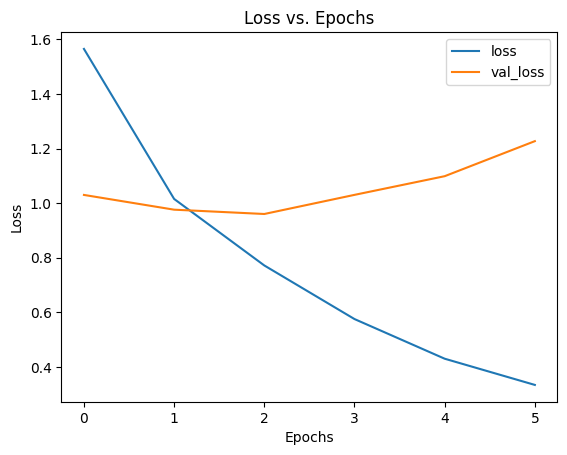

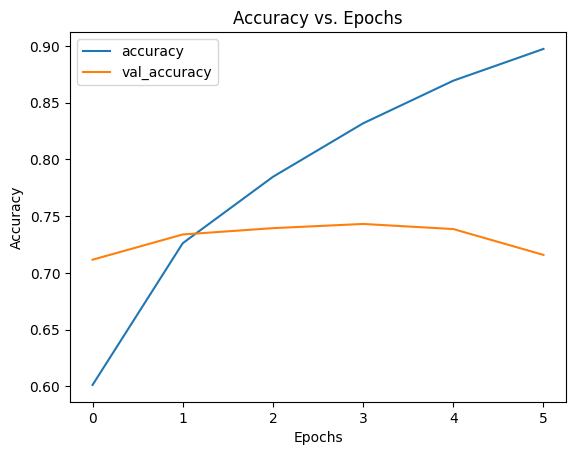

In [180]:
ml_toolbox.analysis.history.plot_history(model_2_history, metric='loss')
ml_toolbox.analysis.history.plot_history(model_2_history, metric='accuracy')

In [181]:
model_2_results = generate_prediction_metrics(model_2, test_data)
model_2_results

Completed Predictions: 0.0%
Completed Predictions: 10.0%
Completed Predictions: 20.0%
Completed Predictions: 30.0%
Completed Predictions: 40.0%
Completed Predictions: 50.0%
Completed Predictions: 60.0%
Completed Predictions: 70.0%
Completed Predictions: 80.0%
Completed Predictions: 90.0%


ClassificationPredictionMetrics(accuracy=0.7327920792079208, precision=0.7516711922450579, recall=0.7327920792079208, f1=0.7331222898184744, name='model_2_fine_tune_20')

## Analysis

After running a handful of experiments, I want to see how each experiment performed.

In [182]:
all_results = [
    model_0_results,
    model_1_results,
    model_2_results,
]

all_results_df = ml_toolbox.analysis.classification.generate_prediction_metrics_dataframe(all_results)
all_results_df

,accuracy,precision,recall,f1
model_0_feature_extraction,0.725267,0.733042,0.725267,0.724435
model_1_fine_tune_40,0.733426,0.755638,0.733426,0.734685
model_2_fine_tune_20,0.732792,0.751671,0.732792,0.733122


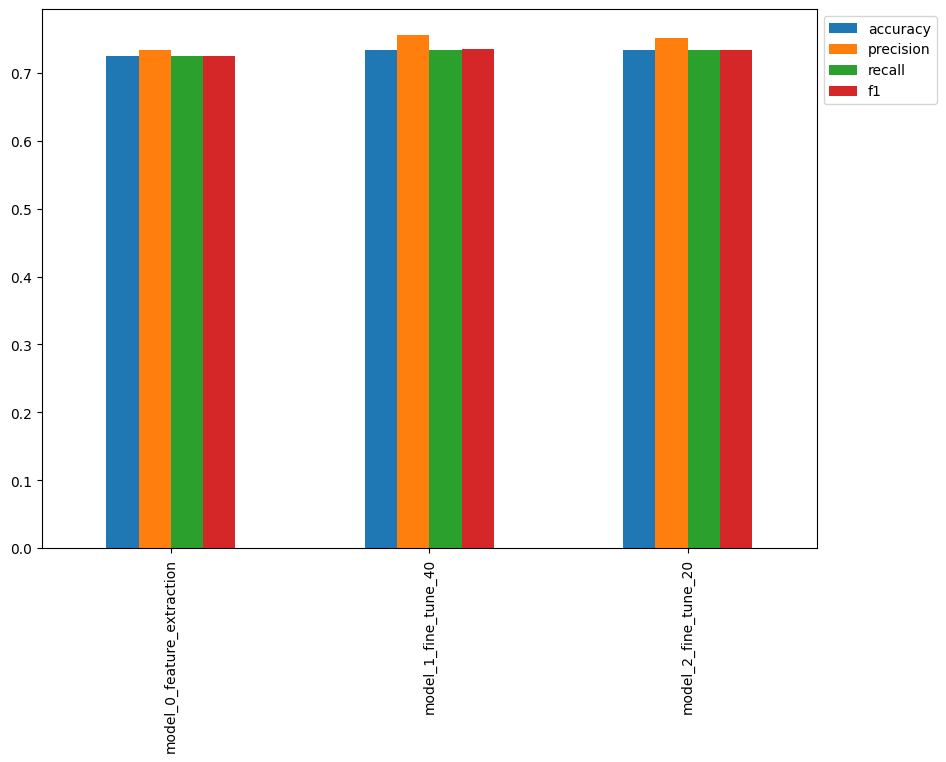

In [183]:
# Plot and compare all of the model results
all_results_df.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))